##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#   
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# DeepDream

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/deepdream"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/deepdream.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/deepdream.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/deepdream.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial contains a minimal implementation of DeepDream, as described in this [blog post](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) by Alexander Mordvintsev.

DeepDream is an experiment that visualizes the patterns learned by a neural network. Similar to when a child watches clouds and tries to interpret random shapes, DeepDream over-interprets and enhances the patterns it sees in an image.

It does so by forwarding an image through the network, then calculating the gradient of the image with respect to the activations of a particular layer. The image is then modified to increase these activations, enhancing the patterns seen by the network, and resulting in a dream-like image. This process was dubbed "Inceptionism" (a reference to [InceptionNet](https://arxiv.org/pdf/1409.4842.pdf), and the [movie](https://en.wikipedia.org/wiki/Inception) Inception).

Let's demonstrate how you can make a neural network "dream" and enhance the surreal patterns it sees in an image.

![Dogception](https://www.tensorflow.org/tutorials/generative/images/dogception.png)

In [2]:
import tensorflow as tf

In [3]:
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

## Choose an image to dream-ify

For this tutorial, let's use an image of a [labrador](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg).

In [4]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

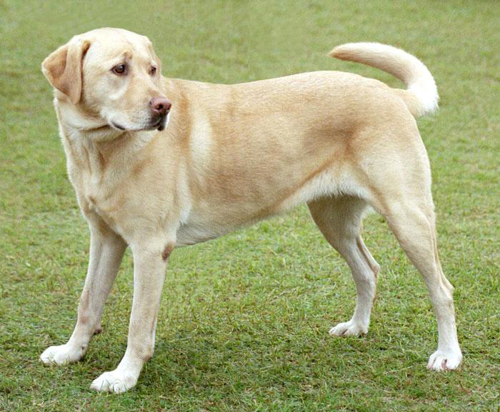

In [5]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

## Prepare the feature extraction model

Download and prepare a pre-trained image classification model. You will use [InceptionV3](https://keras.io/applications/#inceptionv3) which is similar to the model originally used in DeepDream. Note that any [pre-trained model](https://keras.io/applications/#models-for-image-classification-with-weights-trained-on-imagenet) will work, although you will have to adjust the layer names below if you change this.

In [6]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

The idea in DeepDream is to choose a layer (or layers) and maximize the "loss" in a way that the image increasingly "excites" the layers. The complexity of the features incorporated depends on layers chosen by you, i.e, lower layers produce strokes or simple patterns, while deeper layers give sophisticated features in images, or even whole objects.

The InceptionV3 architecture is quite large (for a graph of the model architecture see TensorFlow's [research repo](https://github.com/tensorflow/models/tree/master/research/inception)). For DeepDream, the layers of  interest are those where the convolutions are concatenated. There are 11 of these layers in InceptionV3, named 'mixed0' though 'mixed10'. Using different layers will result in different dream-like images. Deeper layers respond to higher-level features (such as eyes and faces), while earlier layers respond to simpler features (such as edges, shapes, and textures). Feel free to experiment with the layers selected below, but keep in mind that deeper layers (those with a higher index) will take longer to train on since the gradient computation is deeper.

In [7]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

## Calculate loss

The loss is the sum of the activations in the chosen layers. The loss is normalized at each layer so the contribution from larger layers does not outweigh smaller layers. Normally, loss is a quantity you wish to minimize via gradient descent. In DeepDream, you will maximize this loss via gradient ascent.

In [8]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

## Gradient ascent

Once you have calculated the loss for the chosen layers, all that is left is to calculate the gradients with respect to the image, and add them to the original image. 

Adding the gradients to the image enhances the patterns seen by the network. At each step, you will have created an image that increasingly excites the activations of certain layers in the network.

The method that does this, below, is wrapped in a `tf.function` for performance. It uses an `input_signature` to ensure that the function is not retraced for different image sizes or `steps`/`step_size` values. See the [Concrete functions guide](../../guide/concrete_function.ipynb) for details.

In [9]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

#   def __call__(self, img_a, img_b, steps, step_size, a_weight=0.5):
#       print("Tracing")
#       loss = tf.constant(0.0)
#       for n in tf.range(steps):
#         with tf.GradientTape() as tape:
#           # This needs gradients relative to `img`
#           # `GradientTape` only watches `tf.Variable`s by default
#           tape.watch(img_a)
#           loss = calc_loss(img_a, self.model)

#         with tf.GradientTape() as tape:
#           # This needs gradients relative to `img`
#           # `GradientTape` only watches `tf.Variable`s by default
#           tape.watch(img_b)
#           loss += calc_loss(img_b, self.model)

#         # Calculate the gradient of the loss with respect to the pixels of the input image.
#         gradients = tape.gradient(loss, img)

#         # Normalize the gradients.
#         gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
#         # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
#         # You can update the image by directly adding the gradients (because they're the same shape!)
#         img = img + gradients*step_size
#         img = tf.clip_by_value(img, -1, 1)

#       return loss, img

In [10]:
deepdream = DeepDream(dream_model)

## Main Loop

In [11]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))
    
    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

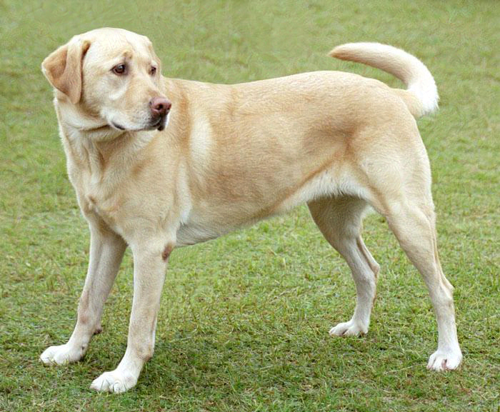

6.500153541564941


In [14]:
import time
start_time = time.time()
dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=1, step_size=0.01)
print(time.time() - start_time)

## Taking it up an octave

Pretty good, but there are a few issues with this first attempt: 

  1. The output is noisy (this could be addressed with a `tf.image.total_variation` loss).
  1. The image is low resolution.
  1. The patterns appear like they're all happening at the same granularity.
  
One approach that addresses all these problems is applying gradient ascent at different scales. This will allow patterns generated at smaller scales to be incorporated into patterns at higher scales and filled in with additional detail.

To do this you can perform the previous gradient ascent approach, then increase the size of the image (which is referred to as an octave), and repeat this process for multiple octaves.


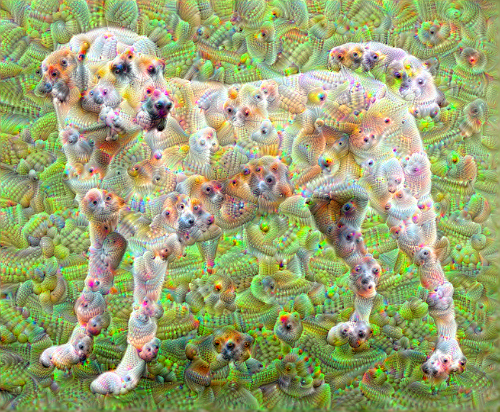

13.741069316864014

In [12]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start

## Optional: Scaling up with tiles

One thing to consider is that as the image increases in size, so will the time and memory necessary to perform the gradient calculation. The above octave implementation will not work on very large images, or many octaves.

To avoid this issue you can split the image into tiles and compute the gradient for each tile.

Applying random shifts to the image before each tiled computation prevents tile seams from appearing.

Start by implementing the random shift:

In [13]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  shift_down, shift_right = shift[0],shift[1] 
  img_rolled = tf.roll(tf.roll(img, shift_right, axis=1), shift_down, axis=0)
  return shift_down, shift_right, img_rolled

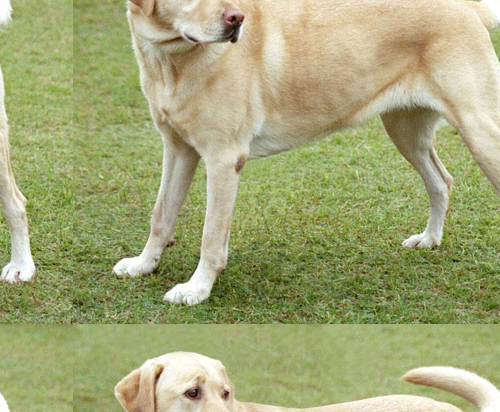

In [17]:
shift_down, shift_right, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

Here is a tiled equivalent of the `deepdream` function defined earlier:

In [14]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, tile_size=512):
    shift_down, shift_right, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)
    
    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1), -shift_down, axis=0)

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients 

In [15]:
get_tiled_gradients = TiledGradients(dream_model)

Putting this together gives a scalable, octave-aware deepdream implementation:

In [16]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3, show_progress=True,
                                get_tiled_gradients_func=get_tiled_gradients):
  base_shape = tf.shape(img)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    img = tf.image.resize(img, tf.cast(new_size, tf.int32))

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients_func(img)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if show_progress and step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))
    
  result = deprocess(img)
  return result

In [21]:
import os

from os import path
from wordcloud import WordCloud

def get_word_cloud(filename):
    # get data directory (using getcwd() is needed to support running example in generated IPython notebook)
    d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

    # Read the whole text.
    text = open(path.join(d, filename)).read().lower()

    # Generate a word cloud image
    wordcloud = WordCloud().generate(text)

    # Display the generated image:
    # the matplotlib way:
    import matplotlib.pyplot as plt
    # plt.imshow(wordcloud, interpolation='bilinear')
    # plt.axis("off")

    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

    # The pil way (if you don't have matplotlib)
    image = wordcloud.to_image()
    image.show()
    return wordcloud

def get_topn_words(wc, n):
    return list(wc.words_.keys())[:n]

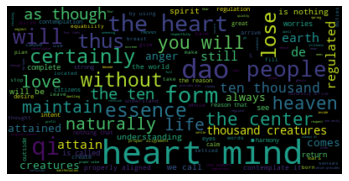

['heart mind',
 'dao',
 'qi',
 'form',
 'the heart',
 'people',
 'will',
 'thus',
 'lose',
 'certainly',
 'essence',
 'without',
 'heaven',
 'the center',
 'you will']

In [22]:
it_wc = get_word_cloud('inward_training.txt')
it_words = get_topn_words(it_wc, 15)
it_words

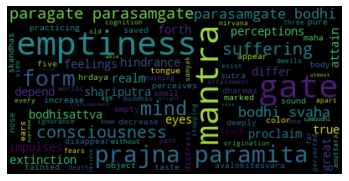

['emptiness',
 'mantra',
 'gate',
 'prajna paramita',
 'form',
 'mind',
 'suffering',
 'consciousness',
 'paragate parasamgate',
 'parasamgate bodhi',
 'bodhi svaha',
 'bodhisattva',
 'shariputra',
 'differ',
 'true']

In [23]:
hs_wc = get_word_cloud('heart_sutra.txt')
hs_words = get_topn_words(hs_wc, 15)
hs_words

In [222]:
from bootleg_google_images_download import googleimagesdownload   #importing the library

response = googleimagesdownload()   #class instantiation

it_select_words = ['heart mind',
 'dao',
 'qi',
 'the heart',
 'will',
 'essence',
 'heaven',
 'the center']

it_arguments = {"keywords":",".join(it_select_words), "prefix_keywords":"landscape", "limit":2,"print_urls":False}   #creating list of arguments
it_paths = response.download(it_arguments)   #passing the arguments to the function
print(it_paths)   #printing absolute paths of the downloaded images


Item no.: 1 --> Item name = landscape heart mind
Evaluating...
Starting Download...
Completed Image ====> 1.51gmi0b40hl._sx331_bo1,204,203,200_.jpg
Completed Image ====> 2.800px-huang_gongwang._dwelling_in_the_fuchun_mountains._detail._national_palace_museum%2c_taipei.jpg

Errors: 0


Item no.: 2 --> Item name = landscape dao
Evaluating...
Starting Download...
Completed Image ====> 1.1960.9.jpg
Completed Image ====> 2.landscape-sunrise-mountain-phu-chi-dao-thailand_34138-233.jpg

Errors: 0


Item no.: 3 --> Item name = landscape qi
Evaluating...
Starting Download...
Completed Image ====> 1.qi-baishi-12-landscape-screens-wechat-image-1024x319.jpg
Completed Image ====> 2.qi-baishi-landscape.jpg

Errors: 0


Item no.: 4 --> Item name = landscape the heart
Evaluating...
Starting Download...
Completed Image ====> 1.cropped-shutterstock_83588584-1.jpg
Completed Image ====> 2.14.jpg

Errors: 0


Item no.: 5 --> Item name = landscape will
Evaluating...
Starting Download...
Completed Image ===

In [220]:
from bootleg_google_images_download import googleimagesdownload   #importing the library

response = googleimagesdownload()   #class instantiation

hs_arguments = {"keywords":",".join(hs_words), "prefix_keywords":"landscape", "limit":3,"print_urls":False}   #creating list of arguments
hs_paths = response.download(hs_arguments)   #passing the arguments to the function
print(hs_paths)   #printing absolute paths of the downloaded images


Item no.: 1 --> Item name = landscape emptiness
Evaluating...
Starting Download...
Completed Image ====> 1.maxresdefault.jpg
Completed Image ====> 2.f5e92776-3e21-4286-bd54-43dfbc6f9a12.jpg
Completed Image ====> 3.emptiness.png

Errors: 0


Item no.: 2 --> Item name = landscape mantra
Evaluating...
Starting Download...
Completed Image ====> 1.dscf2341.jpg
Invalid image format 'text/html'. Skipping...
Completed Image ====> 2.3-20-1-8-7-26-43m.jpg
Completed Image ====> 3.6455fdf542a355abe2e622706dfe1d42.jpg

Errors: 1


Item no.: 3 --> Item name = landscape gate
Evaluating...
Starting Download...
Completed Image ====> 1.d66173496ca830df45a9821f8ae7bf90.jpg
Completed Image ====> 2.livinggreen-corten-steel-garden-gate.jpg
Completed Image ====> 3.be352a34978da0a52c586c62f5f3a0c8.jpg

Errors: 0


Item no.: 4 --> Item name = landscape prajna paramita
Evaluating...
Starting Download...
Completed Image ====> 1.the-full-title-of-this-sutra-is-prajna-paramita-heart-sutra-of-which-amaj06.jpg
Comp

In [24]:
[layer.name for layer in base_model.layers if 'mixed' in layer.name]

['mixed0',
 'mixed1',
 'mixed2',
 'mixed3',
 'mixed4',
 'mixed5',
 'mixed6',
 'mixed7',
 'mixed8',
 'mixed9_0',
 'mixed9',
 'mixed9_1',
 'mixed10']

In [25]:
# Maximize the activations of these layers
# names = ['mixed0', 'mixed1']
names = ['mixed0', 'mixed1']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)
get_tiled_gradients = TiledGradients(dream_model)

In [26]:
# show(
#     tf.image.convert_image_dtype(
#         tf.image.central_crop(
#             tf.image.resize(img, [int(img.shape[0] * 1.5), int(img.shape[1] * 1.1)]),
#             0.75
#         )/ 255.0,
        
#         dtype=tf.uint8)
    
# )

In [27]:
# show(tf.image.resize(img, tf.Tensor(img.shape[0] * 1.1, img.shape[1] * 1.1, )))
# show(tf.image.resize(img, [int(img.shape[0] * 1.1), int(img.shape[1] * 1.1)]))

In [28]:
def create_tiled_gradients_function(names = ['mixed0', 'mixed1']):
    layers = [base_model.get_layer(name).output for name in names]

    # Create the feature extraction model
    dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)
    get_tiled_gradients = TiledGradients(dream_model)
    return get_tiled_gradients

def create_zooming_movie(original_imgs, frames_per_img=10, zoom_ratio=0.1,
                         do_dream=True, change_tiling_every=0,
                         steps_per_octave=5):
    original_imgs = [np.array(PIL.Image.fromarray(img).resize((500,412))) for img in original_imgs]
    imgs = [original_imgs[0]]
    curr_img = original_imgs[0]
    
    names_list = ['mixed0', 'mixed1', 'mixed2', 'mixed3', 'mixed4']

    for i in range(len(original_imgs)):
        print(curr_img.shape)
        next_img = original_imgs[(i+1)%len(original_imgs)]
        
        if change_tiling_every > 0 and i % change_tiling_every == 0:
            names = np.random.choice(names_list, 2)
            custom_tiled_gradients_func = create_tiled_gradients_function(names)
        else:
            custom_tiled_gradients_func = get_tiled_gradients

        for j in range(frames_per_img):
            curr_kept = (frames_per_img - j) / (frames_per_img - j + 1)
 
            curr_img = tf.image.resize(curr_img, base_shape)
            curr_img = curr_img*(curr_kept) + next_img*(1 - curr_kept)
            curr_img = tf.image.convert_image_dtype(curr_img/255.0, dtype=tf.uint8)
            
            if do_dream:
                img = run_deep_dream_with_octaves(img=curr_img, step_size=0.01,
                    steps_per_octave=steps_per_octave, octaves=range(-1,2),
                    octave_scale=1.5, show_progress=False,
                    get_tiled_gradients_func=custom_tiled_gradients_func)
            else:
                img = curr_img

            display.clear_output(wait=True)
            img = tf.image.central_crop(img, 1 - zoom_ratio)
            img = tf.image.resize(img, base_shape)
            img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
            show(img)
            imgs.append(img)

            curr_img = img
            
    return imgs

In [29]:
# tf.image.convert_image_dtype(tf.image.resize(img, [206,250]) / 255, dtype=tf.uint8)
# tf.image.resize(img, [412,500]) + original_img

In [30]:
# tf.math.multiply(tf.image.convert_image_dtype(tf.image.resize(img, base_shape)/255.0, dtype=tf.uint8), 1.1)

# tf.image.convert_image_dtype(tf.image.resize(img, base_shape)/255.0, dtype=tf.uint8).
# tf.image.convert_image_dtype(tf.image.resize(img, base_shape)/255.0, dtype=tf.float32)
# tf.image.resize(img, base_shape)/255.0

In [32]:
# [0][list(hs_paths[0].keys())[0]]

In [33]:
np.array(PIL.Image.open('flowers.jpg')).shape

(240, 320, 3)

In [34]:
hs_words

['emptiness',
 'mantra',
 'gate',
 'prajna paramita',
 'form',
 'mind',
 'suffering',
 'consciousness',
 'paragate parasamgate',
 'parasamgate bodhi',
 'bodhi svaha',
 'bodhisattva',
 'shariputra',
 'differ',
 'true']

In [43]:
source_images = []
def crop_center(img,cropx,cropy):
    y,x = img.shape[:2]
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

import os

valid_keywords = []

for keyword in hs_words + it_words:
    dir_name = 'downloads/landscape ' + keyword
    if not os.path.exists(dir_name):
        continue
    for path in os.listdir(dir_name):
        full_path = os.path.join(dir_name, path)
        if os.path.exists(full_path) and ('jpg' in path or 'png' in path or 'bmp' in path):
            source_image = np.array(PIL.Image.open(full_path))
            limiting_dim = min(source_image.shape[0] / 412, source_image.shape[1] / 500)
            source_image = crop_center(source_image, int(500 * limiting_dim), int(412 * limiting_dim))
            if source_image.shape[0] != 0:
                source_images.append(source_image)
                valid_keywords.append(keyword)
        

In [44]:
valid_keywords

['emptiness',
 'mantra',
 'gate',
 'prajna paramita',
 'form',
 'consciousness',
 'paragate parasamgate',
 'parasamgate bodhi',
 'bodhi svaha',
 'bodhisattva',
 'shariputra',
 'differ',
 'true',
 'heart mind',
 'dao',
 'qi',
 'form',
 'the heart',
 'will',
 'essence',
 'heaven',
 'the center']

In [45]:
[img.shape for img in source_images]

[(720, 873, 3),
 (556, 674, 3),
 (412, 500, 3),
 (955, 1160, 3),
 (800, 970, 3),
 (840, 1019, 3),
 (479, 582, 3),
 (360, 436, 3),
 (720, 873, 3),
 (1155, 1401, 3),
 (389, 472, 3),
 (743, 901, 3),
 (533, 648, 3),
 (292, 354, 3),
 (215, 261, 3),
 (319, 387, 3),
 (800, 970, 3),
 (386, 468, 3),
 (675, 819, 3),
 (720, 873, 3),
 (487, 592, 3),
 (533, 646, 3)]

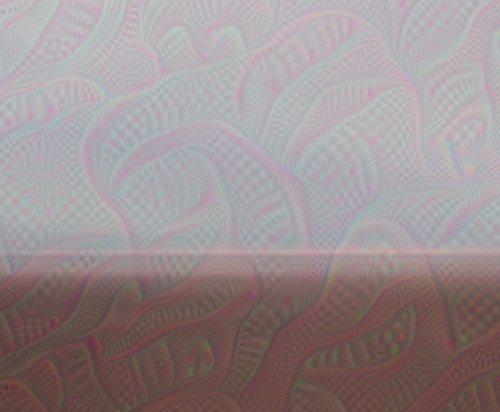

In [46]:
# imgs = create_zooming_movie([original_img, original_img[:,::-1,:]], frames_per_img=50, zoom_ratio=0.05)
imgs = create_zooming_movie(source_images, frames_per_img=50, zoom_ratio=0.04,
                            change_tiling_every=2, steps_per_octave=3)

In [48]:
# imgs = create_zooming_movie([original_img, original_img[:,::-1,:]], frames_per_img=50, zoom_ratio=0.05)
# imgs = create_zooming_movie(source_images, frames_per_img=50, zoom_ratio=0.05, change_tiling_every=2)

In [55]:
new_np_imgs = [imgs[0]] + [img.numpy() for img in imgs[1:]]

In [56]:
np.save('both_images_between.npy', new_np_imgs)

In [57]:
from moviepy.editor import *

clip = ImageSequenceClip(new_np_imgs, fps=10)

audio_clip = AudioFileClip(
    'Heart Sutra in English.mp3'
).set_duration(clip.duration)

# audio_clip = audio_clip.subclip(t_start=video_clips[0].duration)

clip = clip.set_audio(audio_clip)

# clip.write_videofile(
#     'heart_sutra_inner_training.mp4'
# )

In [58]:
len(imgs), len(valid_keywords)

(1101, 22)

In [62]:
valid_keywords

['emptiness',
 'mantra',
 'gate',
 'prajna paramita',
 'form',
 'consciousness',
 'paragate parasamgate',
 'parasamgate bodhi',
 'bodhi svaha',
 'bodhisattva',
 'shariputra',
 'differ',
 'true',
 'heart mind',
 'dao',
 'qi',
 'form',
 'the heart',
 'will',
 'essence',
 'heaven',
 'the center']

In [60]:
os.environ['IMAGEMAGICK_BINARY'] = '/usr/lib/x86_64-linux-gnu/ImageMagick-6.8.9/bin-Q16/convert'

In [61]:
header_texts = [name[10:].capitalize() for name in valid_keywords]
text_clips = [clip]
for i, name in enumerate(header_texts):
    text_clip = TextClip(name, font="Amiri-Bold", fontsize=40, color="black").set_position(('center', 'bottom')).set_duration(5).set_start(5 * i)
    text_clips.append(text_clip)

compo = CompositeVideoClip(text_clips)
compo.write_videofile(
    'heart_sutra_inner_training_titled_cropped_' + str(int(time.time())) + '_.mp4'
)

OSError: MoviePy Error: creation of None failed because of the following error:

convert: no images defined `PNG32:/tmp/tmpo35z4mg2.png' @ error/convert.c/ConvertImageCommand/3210.
.

.This error can be due to the fact that ImageMagick is not installed on your computer, or (for Windows users) that you didn't specify the path to the ImageMagick binary in file conf.py, or that the path you specified is incorrect

In [47]:
# os.environ['IMAGEMAGICK_BINARY'] = '/usr/lib/x86_64-linux-gnu/ImageMagick-6.8.9/bin-Q16/convert'

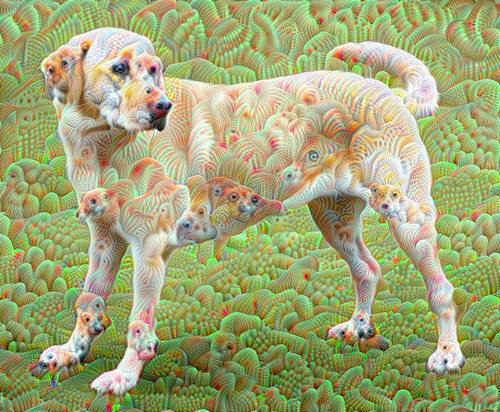

1.586029291152954


In [71]:
start_time = time.time()
img = run_deep_dream_with_octaves(img=original_img, step_size=0.02,
    steps_per_octave=30, octaves=range(-1,2), octave_scale=1.5, show_progress=False)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)
print(time.time() - start_time)

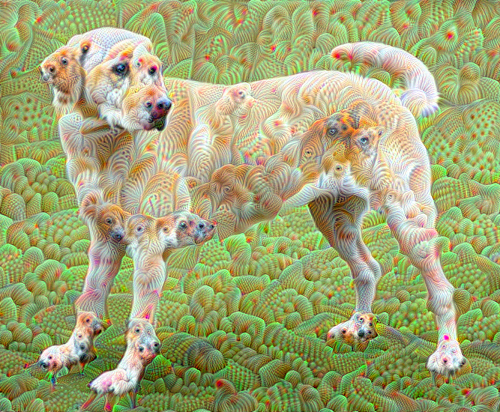

In [57]:
display.clear_output(wait=True)
show(img)
display.clear_output(wait=True)
show(original_img)
display.clear_output(wait=True)
show(img)
display.clear_output(wait=True)
show(original_img)
display.clear_output(wait=True)
show(img)
display.clear_output(wait=True)
show(original_img)
display.clear_output(wait=True)
show(img)
display.clear_output(wait=True)
show(original_img)
display.clear_output(wait=True)
show(img)
display.clear_output(wait=True)
show(original_img)
display.clear_output(wait=True)
show(img)
display.clear_output(wait=True)
show(original_img)
display.clear_output(wait=True)
show(img)

Much better! Play around with the number of octaves, octave scale, and activated layers to change how your DeepDream-ed image looks.

Readers might also be interested in [TensorFlow Lucid](https://github.com/tensorflow/lucid) which expands on ideas introduced in this tutorial to visualize and interpret neural networks.